In [1]:
import pandas as pd
import xlrd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cross_validation import StratifiedKFold
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from numpy.random import seed
from nltk.corpus import stopwords
stop = stopwords.words('english')
from textblob import Word
import nltk
nltk.download('wordnet')
from sklearn.pipeline import Pipeline, FeatureUnion
import sys
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.ensemble import  RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import decomposition, ensemble
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input, Flatten, Activation
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")
from keras.utils import to_categorical
from scipy.stats import randint
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from keras.preprocessing import text, sequence
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from textblob import TextBlob
from gensim import corpora
import gensim
import pickle
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim
from imblearn.pipeline import Pipeline 
from sklearn.preprocessing import FunctionTransformer
warnings.filterwarnings("ignore", category=DeprecationWarning) 


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[nltk_data] Downloading package wordnet to /Users/itziar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using TensorFlow backend.


In [85]:
df = pd.read_excel('/Users/itziar/Downloads/DS_NLP_Assignment_final/sentences_with_sentiment.xlsx', names=['ID', 'Sentence', 'Positive', 'Negative', 'Neutral'])
df.head()

,ID,Sentence,Positive,Negative,Neutral
0,1,The results in 2nd line treatment show an ORR ...,1,0,0
1,2,The long duration of response and high durable...,1,0,0
2,3,The median OS time in the updated results exce...,0,0,1
3,4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0
4,5,"The data provided in 1st line, although prelim...",1,0,0


In [89]:
df[df.Positive == 1].shape[0]/df.shape[0], df[df.Neutral == 1].shape[0]/df.shape[0], df[df.Negative == 1].shape[0]/df.shape[0]
(df[df.Positive == 1].shape[0]/df.shape[0])/(df[df.Neutral == 1].shape[0]/df.shape[0]), (df[df.Positive == 1].shape[0]/df.shape[0])/(df[df.Negative == 1].shape[0]/df.shape[0])

(2.2857142857142856, 4.444444444444445)

Data is inbalanced. There are 60% positive sentiments, 26% neutral sentiments and 14% negative sentiments. We will try some data balancing techniques later.

In [4]:
df['Positive'][df.Positive == 1] = "Positive"
df['Positive'][df.Positive == 0] = ""

df['Negative'][df.Negative == 1] = "Negative"
df['Negative'][df.Negative == 0] = ""

df['Neutral'][df.Neutral == 1] = "Neutral"
df['Neutral'][df.Neutral == 0] = ""


df['Sentiment'] = df.Positive + df.Negative + df.Neutral

In [5]:
df.Sentiment = LabelEncoder().fit_transform(df.Sentiment)


### Feature engineering

In [6]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))



In [7]:
df['char_count'] = df['Sentence'].apply(len)
df['word_count'] = df['Sentence'].apply(lambda x: len(x.split()))
df['word_density'] = df['char_count'] / (df['word_count']+1)
df['upper_case_word_count'] = df['Sentence'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
df['numerics'] = df['Sentence'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df['stopwords'] = df['Sentence'].apply(lambda x: len([x for x in x.split() if x in stop]))
df['avg_word'] = df['Sentence'].apply(lambda x: avg_word(x))



In [8]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

df['noun_count'] = df['Sentence'].apply(lambda x: check_pos_tag(x, 'noun'))
df['verb_count'] = df['Sentence'].apply(lambda x: check_pos_tag(x, 'verb'))
df['adj_count'] = df['Sentence'].apply(lambda x: check_pos_tag(x, 'adj'))
df['adv_count'] = df['Sentence'].apply(lambda x: check_pos_tag(x, 'adv'))
df['pron_count'] = df['Sentence'].apply(lambda x: check_pos_tag(x, 'pron'))

remove stopwords, convert to lowercase, remove punctuation and lemmatize. 

In [9]:
df['Sentence'] = df['Sentence'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['Sentence'] = df['Sentence'].str.replace('[^\w\s]','')
df['Sentence'] = df['Sentence'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['Sentence'] = df['Sentence'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [10]:
df['polarity'] = df['Sentence'].apply(lambda x: TextBlob(x).sentiment[0] )
df['subjectivity'] = df['Sentence'].apply(lambda x: TextBlob(x).sentiment[1] )


In [11]:
df.drop(['Positive', 'Negative', 'Neutral'], axis = 1).head()

,ID,Sentence,Sentiment,char_count,word_count,word_density,upper_case_word_count,numerics,stopwords,avg_word,noun_count,verb_count,adj_count,adv_count,pron_count,polarity,subjectivity
0,1,result 2nd line treatment show orr 33 patient ...,2,133,23,5.541667,2,0,8,4.826087,9,3,2,0,0,0.025000,0.175000
1,2,long duration response high durable response r...,2,170,24,6.800000,0,0,7,6.125000,6,3,8,1,0,0.055000,0.470000
2,3,median o time updated result exceeded 1 year,1,57,11,4.750000,1,1,2,4.272727,4,1,2,0,0,0.000000,0.000000
3,4,therefore clinical benefit 2nd line treatment ...,2,161,23,6.708333,0,0,9,6.043478,5,5,3,2,0,0.291667,0.458333
4,5,data provided 1st line although preliminary sh...,2,247,41,5.880952,0,0,14,5.048780,14,3,5,1,0,-0.083333,0.266667


The sentiment polarity predicted using TextBlob does not match with the labels provided in this dataset for many cases.

<Figure size 432x288 with 0 Axes>

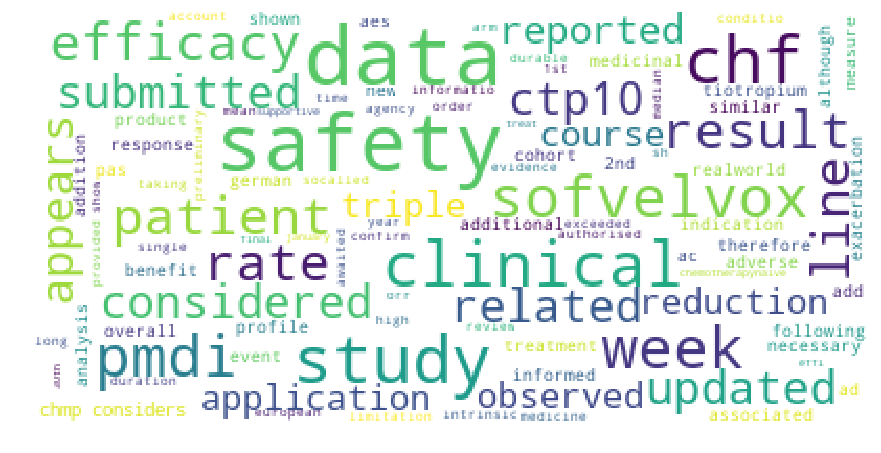

In [12]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=100,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df['Sentence']))

print(wordcloud)
fig = plt.figure(1)
plt.figure( figsize=(15,10) )
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('/Users/itziar/Documents/wordcloud2.png')
plt.show()



In [13]:
df_num = df.drop(['Sentence', 'Positive', 'Neutral', 'Negative', 'ID'], axis=1)

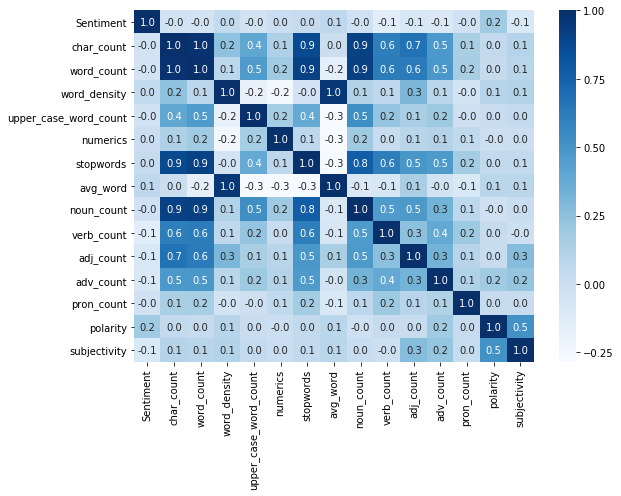

In [14]:
corr = df_num.corr()
plt.subplots(figsize=(9,7))
sns.heatmap(corr, cmap="Blues", annot = True, annot_kws={"size": 10}, fmt='.1f')
plt.tight_layout()
plt.savefig('/Users/itziar/Documents/correlation2.png')

There is no correlation between the features engineered and the Sentiment label

### Count vectors and TF-IDF as features

In [15]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')

# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)

series_text = pd.Series(df.Sentence)

sentence_count = count_vect.fit_transform(series_text)
sentence_tfidf = tfidf_vect.fit_transform(series_text)
sentence_tfidf_ngram = tfidf_vect_ngram.fit_transform(series_text)
sentence_tfidf_ngram_chars = tfidf_vect_ngram_chars.fit_transform(series_text)


### Topics with LDA

In [16]:
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)

X_topics = lda_model.fit_transform(count_vect.fit_transform(df.Sentence))
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
print (topic_summaries)

['ctp10 study term long extension safety data efficacy provide 2', 'efficacy rate treatment clinically mabthera shown ctp10 subject data sma', 'safety data considered concern available ctp10 additional profile patient period', 'combination infusion reported infection common event related reaction analysis lenvatinib', 'study reported data phase subject 3 assessed safety due one', 'risk addressed section adequately various rmp important identified smpc potentially', 'compared increase use addition section appears conclusion barrier concerning sofvel', 'dos higher could efficacy safety proposed immune related recommendation risk', 'rate overall compared however two difference indication general exposed total', 'product incidence reference group similar lower safety patient overall aes', 'aes related including appetite spasm decreased vomiting rash muscle potentially', 'number patient sufficient including compensated studied cirrhosis substantial sofvelvox product', 'humira bioequivalence

### Topic visualizaion

In [17]:

tokenized_sents = [word_tokenize(i) for i in df.Sentence]
dictionary = corpora.Dictionary(tokenized_sents)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
corpus_yes = [dictionary.doc2bow(text) for text in tokenized_sents]
pickle.dump(corpus_yes, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

NUM_TOPICS = 10
ldamodel_yes = gensim.models.ldamodel.LdaModel(corpus_yes, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel_yes.save('model5.gensim')
topics = ldamodel_yes.print_topics(num_words=5)
for topic in topics:
    print (topic)

(0, '0.254*"provided" + 0.194*"additional" + 0.181*"study" + 0.087*"clinical" + 0.045*"support"')
(1, '0.436*"result" + 0.404*"efficacy" + 0.084*"ctp10" + 0.006*"safety" + 0.004*"combination"')
(2, '0.279*"product" + 0.239*"clinical" + 0.099*"efficacy" + 0.089*"chmp" + 0.086*"reference"')
(3, '0.353*"safety" + 0.243*"profile" + 0.099*"product" + 0.083*"reference" + 0.070*"overall"')
(4, '0.662*"week" + 0.200*"chmp" + 0.028*"bioequivalence" + 0.022*"safety" + 0.005*"support"')
(5, '0.206*"data" + 0.151*"safety" + 0.146*"ctp10" + 0.112*"considered" + 0.089*"patient"')
(6, '0.246*"treatment" + 0.220*"patient" + 0.146*"compared" + 0.138*"effect" + 0.137*"difference"')
(7, '0.307*"observed" + 0.252*"rate" + 0.147*"support" + 0.095*"additional" + 0.087*"difference"')
(8, '0.561*"study" + 0.119*"bioequivalence" + 0.078*"efficacy" + 0.068*"patient" + 0.037*"overall"')
(9, '0.268*"data" + 0.161*"subject" + 0.159*"combination" + 0.116*"support" + 0.110*"clinical"')


In [18]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus_yes = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus_yes, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

## Model training

We will train different models (later some NN architectures):
    Logistic Regression, Multinomial Naive Bayes, Linear SVC, AdaBoost Classifier and Extreme Gradien Boosting Classifier (the two last ones with hypermarameter tuning).
 We use 5 fold cross validation.

In [19]:
lr = LogisticRegression()
nb = naive_bayes.MultinomialNB()
svc = LinearSVC()

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

def lr_cv(splits, X, Y, pipeline, average_method):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        classifier_fit = pipeline.fit(X[train], Y[train])
        prediction = classifier_fit.predict(X[test])
        scores = classifier_fit.score(X[test],Y[test])
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)

    print('              negative    neutral     positive')
    print('precision:',precision_score(Y[test], prediction, average=None))
    print('recall:   ',recall_score(Y[test], prediction, average=None))
    print('f1 score: ',f1_score(Y[test], prediction, average=None))
    print('-'*50)

    print("accuracy: %.2f%%" % (np.mean(accuracy)))
    print("precision: %.2f%%" % (np.mean(precision)))
    print("recall: %.2f%%" % (np.mean(recall)))
    print("f1 score: %.2f%%" % (np.mean(f1)))

### Logistic Regression

In [20]:
pipeline1 = Pipeline([
    ('feats', FeatureUnion([
        ('vectorizer1', tfidf_vect), 
        ('counter', count_vect),
        ('vectorizer2', tfidf_vect_ngram)
    ])), 
    ('classifier', lr)])

print(lr_cv(5, df.Sentence, df.Sentiment, pipeline1, 'macro'))


              negative    neutral     positive
precision: [0.75       0.75       0.75609756]
recall:    [0.42857143 0.42857143 0.96875   ]
f1 score:  [0.54545455 0.54545455 0.84931507]
--------------------------------------------------
accuracy: 72.54%
precision: 76.11%
recall: 58.87%
f1 score: 62.62%
None


### Naive Bayes Classifier

In [21]:
pipeline2 = Pipeline([
    ('feats', FeatureUnion([
        ('vectorizer1', tfidf_vect), 
        ('counter', count_vect),
        ('vectorizer2', tfidf_vect_ngram)
    ])), 
    ('classifier', nb)])

print(lr_cv(5, df.Sentence, df.Sentiment, pipeline2, 'macro'))

              negative    neutral     positive
precision: [0.8        0.75       0.70454545]
recall:    [0.57142857 0.21428571 0.96875   ]
f1 score:  [0.66666667 0.33333333 0.81578947]
--------------------------------------------------
accuracy: 71.79%
precision: 77.57%
recall: 57.53%
f1 score: 60.87%
None


### Support Vector Classifier

In [22]:
pipeline3 = Pipeline([
    ('feats', FeatureUnion([
        ('vectorizer1', tfidf_vect), 
        ('counter', count_vect),
        ('vectorizer2', tfidf_vect_ngram)
    ])), 
    ('classifier', svc)])

print(lr_cv(5, df.Sentence, df.Sentiment, pipeline3, 'macro'))

              negative    neutral     positive
precision: [0.6        0.63636364 0.75675676]
recall:    [0.42857143 0.5        0.875     ]
f1 score:  [0.5       0.56      0.8115942]
--------------------------------------------------
accuracy: 72.91%
precision: 72.42%
recall: 61.58%
f1 score: 64.37%
None


### AdaBoost Classifier

In [23]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1), n_estimators = 1000, algorithm = 'SAMME.R', learning_rate = 0.5)

adaHyperParams =  {'n_estimators': randint(10, 1000)}

gridSearchAda = RandomizedSearchCV(estimator=ada_clf, param_distributions=adaHyperParams, n_iter=5,
                                 fit_params=None, cv=5, verbose=0).fit(sentence_tfidf.tocsc(), df.Sentiment)
gridSearchAda.best_params_

{'n_estimators': 360}

In [24]:
pipeline2 = Pipeline([
    ('feats', FeatureUnion([
        ('vectorizer1', tfidf_vect), 
        ('counter', count_vect),
        ('vectorizer2', tfidf_vect_ngram)
    ])), 
    ('classifier', gridSearchAda.best_estimator_)])

print(lr_cv(5, df.Sentence, df.Sentiment, pipeline2, 'macro'))

              negative    neutral     positive
precision: [0.44444444 0.75       0.725     ]
recall:    [0.57142857 0.21428571 0.90625   ]
f1 score:  [0.5        0.33333333 0.80555556]
--------------------------------------------------
accuracy: 65.06%
precision: 67.41%
recall: 51.46%
f1 score: 53.31%
None


### Extreme Gradient Boosting

In [25]:
gbHyperParams = {'n_estimators': randint(10, 1000),
                 'max_depth': randint(1,10)}

gridSearchGB = RandomizedSearchCV(estimator=xgboost.XGBClassifier(), param_distributions=gbHyperParams, n_iter=10,
                                  fit_params=None, cv=None, verbose=0
                                 ).fit(sentence_tfidf_ngram.tocsc(), df.Sentiment)
gridSearchGB.best_params_

{'max_depth': 2, 'n_estimators': 550}

In [26]:
pipeline2 = Pipeline([
    ('feats', FeatureUnion([
        ('vectorizer1', tfidf_vect), 
        ('counter', count_vect),
        ('vectorizer2', tfidf_vect_ngram)
    ])), 
    ('classifier', gridSearchGB.best_estimator_)])

print(lr_cv(5, df.Sentence, df.Sentiment, pipeline2, 'macro'))

              negative    neutral     positive
precision: [0.375      0.38461538 0.71875   ]
recall:    [0.42857143 0.35714286 0.71875   ]
f1 score:  [0.4        0.37037037 0.71875   ]
--------------------------------------------------
accuracy: 63.54%
precision: 59.80%
recall: 51.70%
f1 score: 53.81%
None


Given that the classes are imbalanced, we do not want to get good average performance metrics, we need to look more closely at how each class (in particular the neutral and negative) are performing. With this in mind, SVC and Logistic Regression perform the best, still results are not optimal, Negative and Neutral classes get f1 score of 0.50-0.55 and 0.56-0.55 repectively. 

## Data Augmentation

Now we check if data augmentation techniques can help. We will try two techniques, SMOTE and Randon Oversampling. 

In [27]:
smt = SMOTE(random_state=777, k_neighbors=1)
X_SMOTE, y_SMOTE = smt.fit_sample(sentence_count, df.Sentiment)

ros = RandomOverSampler(random_state=777)
X_ROS, y_ROS = ros.fit_sample(sentence_count, df.Sentiment)

In [28]:
SMOTE_pipeline1 = make_pipeline(count_vect, SMOTE(random_state=777), nb)
SMOTE_pipeline2 = make_pipeline(count_vect, SMOTE(random_state=777),lr)
SMOTE_pipeline3 = make_pipeline(count_vect, SMOTE(random_state=777),gridSearchGB.best_estimator_)

ROS_pipeline1 = make_pipeline(count_vect, RandomOverSampler(random_state=777),nb)
ROS_pipeline2 = make_pipeline(count_vect, RandomOverSampler(random_state=777),lr)
ROS_pipeline3 = make_pipeline(count_vect, RandomOverSampler(random_state=777),gridSearchGB.best_estimator_)


In [29]:
SMOTE_pipeline1 = Pipeline([
    ('feats', FeatureUnion([
        ('vectorizer1', tfidf_vect), 
        ('counter', count_vect),
        ('vectorizer2', tfidf_vect_ngram)
    ])), 
    ('smt', SMOTE(random_state=777)),
    ('classifier', nb)])

SMOTE_pipeline2 = Pipeline([
    ('feats', FeatureUnion([
        ('vectorizer1', tfidf_vect), 
        ('counter', count_vect),
        ('vectorizer2', tfidf_vect_ngram)
    ])), 
    ('smt', SMOTE(random_state=777)),
    ('classifier', lr)])

SMOTE_pipeline3 = Pipeline([
    ('feats', FeatureUnion([
        ('vectorizer1', tfidf_vect), 
        ('counter', count_vect),
        ('vectorizer2', tfidf_vect_ngram)
    ])), 
    ('smt', SMOTE(random_state=777)),
    ('classifier', svc)])

ROS_pipeline1 = Pipeline([
    ('feats', FeatureUnion([
        ('vectorizer1', tfidf_vect), 
        ('counter', count_vect),
        ('vectorizer2', tfidf_vect_ngram)
    ])), 
    ('smt', SMOTE(random_state=777)),
    ('classifier', nb)])

SMOTE_pipeline2 = Pipeline([
    ('feats', FeatureUnion([
        ('vectorizer1', tfidf_vect), 
        ('counter', count_vect),
        ('vectorizer2', tfidf_vect_ngram)
    ])), 
    ('smt', SMOTE(random_state=777)),
    ('classifier', lr)])

ROS_pipeline1 = Pipeline([
    ('feats', FeatureUnion([
        ('vectorizer1', tfidf_vect), 
        ('counter', count_vect),
        ('vectorizer2', tfidf_vect_ngram)
    ])), 
    ('ros', RandomOverSampler(random_state=777)),
    ('classifier', svc)])

ROS_pipeline2 = Pipeline([
    ('feats', FeatureUnion([
        ('vectorizer1', tfidf_vect), 
        ('counter', count_vect),
        ('vectorizer2', tfidf_vect_ngram)
    ])), 
    ('ros', RandomOverSampler(random_state=777)),
    ('classifier', lr)])

ROS_pipeline3 = Pipeline([
    ('feats', FeatureUnion([
        ('vectorizer1', tfidf_vect), 
        ('counter', count_vect),
        ('vectorizer2', tfidf_vect_ngram)
    ])), 
    ('ros', RandomOverSampler(random_state=777)),
    ('classifier', svc)])


In [30]:
print('Data augmentation, NB Classifier')
print(lr_cv(5, df.Sentence, df.Sentiment, SMOTE_pipeline1, 'macro'))
print(lr_cv(5, df.Sentence, df.Sentiment, ROS_pipeline1, 'macro'))


Data augmentation, NB Classifier
              negative    neutral     positive
precision: [0.45454545 0.7        0.8125    ]
recall:    [0.71428571 0.5        0.8125    ]
f1 score:  [0.55555556 0.58333333 0.8125    ]
--------------------------------------------------
accuracy: 71.04%
precision: 63.22%
recall: 61.90%
f1 score: 61.21%
None
              negative    neutral     positive
precision: [0.6        0.63636364 0.75675676]
recall:    [0.42857143 0.5        0.875     ]
f1 score:  [0.5       0.56      0.8115942]
--------------------------------------------------
accuracy: 72.53%
precision: 71.89%
recall: 61.64%
f1 score: 64.40%
None


In [31]:
print('Data augmentation, Logistic Regression Classifier')
print(lr_cv(5, df.Sentence, df.Sentiment, SMOTE_pipeline2, 'macro'))
print(lr_cv(5, df.Sentence, df.Sentiment, ROS_pipeline2, 'macro'))



Data augmentation, Logistic Regression Classifier
              negative    neutral     positive
precision: [0.6        0.66666667 0.77777778]
recall:    [0.42857143 0.57142857 0.875     ]
f1 score:  [0.5        0.61538462 0.82352941]
--------------------------------------------------
accuracy: 70.65%
precision: 66.26%
recall: 60.06%
f1 score: 62.18%
None
              negative    neutral     positive
precision: [0.6        0.66666667 0.77777778]
recall:    [0.42857143 0.57142857 0.875     ]
f1 score:  [0.5        0.61538462 0.82352941]
--------------------------------------------------
accuracy: 72.16%
precision: 68.08%
recall: 61.64%
f1 score: 63.75%
None


In [32]:
print('Data augmentation, Support Vector Classifier')
print(lr_cv(5, df.Sentence, df.Sentiment, SMOTE_pipeline3, 'macro'))
print(lr_cv(5, df.Sentence, df.Sentiment, ROS_pipeline3, 'macro'))



Data augmentation, Support Vector Classifier
              negative    neutral     positive
precision: [0.6        0.63636364 0.75675676]
recall:    [0.42857143 0.5        0.875     ]
f1 score:  [0.5       0.56      0.8115942]
--------------------------------------------------
accuracy: 72.53%
precision: 71.89%
recall: 61.64%
f1 score: 64.40%
None
              negative    neutral     positive
precision: [0.6        0.63636364 0.75675676]
recall:    [0.42857143 0.5        0.875     ]
f1 score:  [0.5       0.56      0.8115942]
--------------------------------------------------
accuracy: 72.53%
precision: 71.89%
recall: 61.64%
f1 score: 64.40%
None


Data augmentation improves some performance metrics but others are worse than before. So it is not really helpful.

## Neural Net Architectures

We will try different architectures. Shallow networks, mlp with three hidden layer, convulational neural networs and lstm.

In [33]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(sentence_tfidf_ngram, df['Sentiment']):
    X_train = sentence_tfidf_ngram[train_index]
    X_train_ = df.Sentence.loc[train_index]
    y_train = df.Sentiment.loc[train_index]
    X_test = sentence_tfidf_ngram[test_index]
    X_test_ = df.Sentence.loc[test_index]
    y_test = df.Sentiment.loc[test_index]


In [34]:
y_binary = to_categorical(y_train)
y_binary_test = to_categorical(y_test)

### Shallow Network 

In [52]:
def create_model_architecture(input_size):
    
    class_weight = {0: 5., 1: 2., 2: 1.}
    seed(1)
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(100, activation="relu")(input_layer)
    
    # create output layer
    output_layer = layers.Dense(3, activation="softmax")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy')
    return classifier 

classifier = create_model_architecture(X_train.shape[1])
earlyStopping=EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')
history = classifier.fit(X_train, y_binary, class_weight = {0: 5., 1: 4, 2: 1.},
                    batch_size=50,
                    epochs=200,
                    verbose=1,
                    callbacks=[earlyStopping],
                    validation_data=( X_test, y_binary_test))
y_pred = classifier.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classifier.summary())
print("NN, Ngram Level TF IDF Vectors, Accuracy:",  accuracy_score(y_pred, np.argmax(y_binary_test, axis=1)))
print(classification_report(y_pred, np.argmax(y_binary_test, axis=1)))


Train on 212 samples, validate on 54 samples
Epoch 1/200
212/212 [==============================] - 1s 4ms/step - loss: 2.5682 - val_loss: 1.0899
Epoch 2/200
212/212 [==============================] - 0s 202us/step - loss: 2.4526 - val_loss: 1.0813
Epoch 3/200
212/212 [==============================] - 0s 174us/step - loss: 2.3561 - val_loss: 1.0718
Epoch 4/200
212/212 [==============================] - 0s 170us/step - loss: 2.2506 - val_loss: 1.0593
Epoch 5/200
212/212 [==============================] - 0s 160us/step - loss: 2.1263 - val_loss: 1.0426
Epoch 6/200
212/212 [==============================] - 0s 166us/step - loss: 1.9896 - val_loss: 1.0242
Epoch 7/200
212/212 [==============================] - 0s 188us/step - loss: 1.8358 - val_loss: 1.0039
Epoch 8/200
212/212 [==============================] - 0s 154us/step - loss: 1.6619 - val_loss: 0.9828
Epoch 9/200
212/212 [==============================] - 0s 154us/step - loss: 1.4854 - val_loss: 0.9598
Epoch 10/200
212/212 [========

### Deeper Network 

In [71]:
def create_model_architecture2(input_size):
    seed(1)
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layers
    hidden_layer = layers.Dense(100, activation="relu")(input_layer)
    dropout1 = layers.Dropout(0.5)(hidden_layer)
    
    hidden_layer2 = layers.Dense(100, activation="relu")(dropout1)
    dropout2 = layers.Dropout(0.5)(hidden_layer2)
    
    hidden_layer3 = layers.Dense(100, activation="relu")(dropout2)
    dropout3 = layers.Dropout(0.5)(hidden_layer3)

    # create output layer
    output_layer = layers.Dense(3, activation="softmax")(dropout3)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.rmsprop(), loss='categorical_crossentropy')
    return classifier 

classifier = create_model_architecture2(X_train.shape[1])
earlyStopping=EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')
history = classifier.fit(X_train, y_binary, class_weight={0: 4., 1: 2, 2: 1.},
                    batch_size=68,
                    epochs=200,
                    verbose=1,
                    callbacks=[earlyStopping],
                    validation_data=( X_test, y_binary_test))
y_pred = classifier.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classifier.summary())
print("NN, Ngram Level TF IDF Vectors, Accuracy:",  accuracy_score(y_pred, np.argmax(y_binary_test, axis=1)))
print(classification_report(y_pred, np.argmax(y_binary_test, axis=1)))

Train on 212 samples, validate on 54 samples
Epoch 1/200
212/212 [==============================] - 1s 6ms/step - loss: 1.8390 - val_loss: 1.0845
Epoch 2/200
212/212 [==============================] - 0s 186us/step - loss: 1.8341 - val_loss: 1.0782
Epoch 3/200
212/212 [==============================] - 0s 142us/step - loss: 1.8159 - val_loss: 1.0681
Epoch 4/200
212/212 [==============================] - 0s 142us/step - loss: 1.8080 - val_loss: 1.0646
Epoch 5/200
212/212 [==============================] - 0s 142us/step - loss: 1.7865 - val_loss: 1.0487
Epoch 6/200
212/212 [==============================] - 0s 142us/step - loss: 1.7455 - val_loss: 1.0274
Epoch 7/200
212/212 [==============================] - 0s 146us/step - loss: 1.7143 - val_loss: 1.0074
Epoch 8/200
212/212 [==============================] - 0s 147us/step - loss: 1.6645 - val_loss: 0.9851
Epoch 9/200
212/212 [==============================] - 0s 149us/step - loss: 1.5980 - val_loss: 0.9551
Epoch 10/200
212/212 [========

A deeper net with the original data is seriously overfitting to the majority class.

### Word Embeddings

In [37]:
# use pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('/Users/itziar/Downloads/wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(df['Sentence'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(X_train_), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(X_test_), maxlen=70)



# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### CNN

In [98]:
def create_cnn(input_size):
    seed(1)
    # Add an Input Layer
    input_layer = layers.Input((input_size, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.5)(output_layer1)
    output_layer2 = layers.Dense(3, activation="softmax")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy')
    
    return model

classifier = create_cnn(train_seq_x.shape[1])
earlyStopping=EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')
history = classifier.fit(train_seq_x, y_binary, class_weight={0: 4.2, 1: 2.5, 2: 1.},
                    batch_size=50,
                    epochs=200, 
                    verbose = 1,
                    callbacks=[earlyStopping],
                    validation_data = (valid_seq_x, y_binary_test))
y_pred = classifier.predict(valid_seq_x)
y_pred = np.argmax(y_pred, axis=1)
print(classifier.summary())
print("CNN, Word Embeddings, Accuracy",  accuracy_score(y_pred, np.argmax(y_binary_test, axis=1)))
print(classification_report(y_pred, np.argmax(y_binary_test, axis=1)))

Train on 212 samples, validate on 54 samples
Epoch 1/200
212/212 [==============================] - 2s 10ms/step - loss: 1.9956 - val_loss: 1.0798
Epoch 2/200
212/212 [==============================] - 0s 876us/step - loss: 1.9801 - val_loss: 1.0108
Epoch 3/200
212/212 [==============================] - 0s 916us/step - loss: 1.9047 - val_loss: 1.0170
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        (None, 70)                0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 70, 300)           368700    
_________________________________________________________________
spatial_dropout1d_21 (Spatia (None, 70, 300)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 68, 100)           90100     
_____________________________________________________

CNN using word embeddings is also overfitting to majority class. We do not have enough data for CNN.

### LSTM

In [108]:
def create_rnn_lstm():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.LSTM(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.55)(output_layer1)
    output_layer2 = layers.Dense(3, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy')
    
    return model

classifier = create_rnn_lstm()
earlyStopping=EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')
history = classifier.fit(train_seq_x, y_binary, class_weight={0: 4, 1: 2, 2: 1.},
                    batch_size=50,
                    epochs=200,
                    verbose=1,
                    callbacks = [earlyStopping],
                    validation_data=(valid_seq_x, y_binary_test))
y_pred = classifier.predict(valid_seq_x)
y_pred = np.argmax(y_pred, axis=1)
print(classifier.summary())
print("RNN-LSTM, Word Embeddings, Accuracy:",  accuracy_score(y_pred, np.argmax(y_binary_test, axis=1)))
print(classification_report(y_pred, np.argmax(y_binary_test, axis=1)))

Train on 212 samples, validate on 54 samples
Epoch 1/200
212/212 [==============================] - 4s 17ms/step - loss: 1.8431 - val_loss: 1.1003
Epoch 2/200
212/212 [==============================] - 0s 2ms/step - loss: 1.8302 - val_loss: 1.0953
Epoch 3/200
212/212 [==============================] - 1s 2ms/step - loss: 1.8171 - val_loss: 1.0857
Epoch 4/200
212/212 [==============================] - 0s 2ms/step - loss: 1.8073 - val_loss: 1.0792
Epoch 5/200
212/212 [==============================] - 0s 2ms/step - loss: 1.7969 - val_loss: 1.0661
Epoch 6/200
212/212 [==============================] - 0s 2ms/step - loss: 1.7697 - val_loss: 1.0672
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        (None, 70)                0         
_________________________________________________________________
embedding_31 (Embedding)     (None, 70, 300)           368700    
__________________